In [1]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr
from math import ceil,sin,cos, atan2, pi, sqrt
import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions22 import *

In [2]:
path_bat = '/home/jvalenti/MOAD/grid/bathymetry_202108.nc'
bat = xr.open_dataset(path_bat,decode_times=False).Bathymetry

In [3]:
path_d='/results2/SalishSea/nowcast-green.202111/31aug22/SalishSea_1h_20220831_20220831_grid_T.nc'
path_area='/results2/SalishSea/nowcast-green.202111/31aug22/SalishSea_1h_20220831_20220831_grid_T.nc'
path_w='/results2/SalishSea/nowcast-green.202111/31aug22/SalishSea_1h_20220831_20220831_grid_W.nc'
path_u='/results2/SalishSea/nowcast-green.202111/31aug22/SalishSea_1h_20220831_20220831_grid_U.nc'
path_v='/results2/SalishSea/nowcast-green.202111/31aug22/SalishSea_1h_20220831_20220831_grid_V.nc'

path_mask = '/ocean/jvalenti/MOAD/grid2/mesh_mask202108_TD.nc'
e3t = xr.open_dataset(path_d,decode_times=False).e3t
Area = xr.open_dataset(path_area,decode_times=False).area
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
zz_ww = xr.open_dataset(path_mask,decode_times=False).gdepw_0
e3t0 = xr.open_dataset(path_mask,decode_times=False).e3t_0

In [4]:
ssh = xr.open_dataset(path_d,decode_times=False).sossheig[:,300:302,297:302]
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy[0,300:302,297:302]
u = xr.open_dataset(path_u,decode_times=False).vozocrtx[:,:,300:302,297:302]
v = xr.open_dataset(path_v,decode_times=False).vomecrty[:,:,300:302,297:302]
w = xr.open_dataset(path_w,decode_times=False).vovecrtz[:,:,300:302,297:302]
depthw = xr.open_dataset(path_w,decode_times=False).depthw
depthu = xr.open_dataset(path_u,decode_times=False).depthu
totaldepth = zz_ww[0, mbathy,300:302, 297:302]

In [5]:
#Define domain
lon = np.array([250.,750., 1250.,1750.,2250.])
lonu = np.array([500.,1000., 1500.,2000.,2500])
latv = np.array([500.,1000.])
lat = np.array([250.,750])
time = np.linspace(0,86400,24)

dim = 5
dep = len(depthu)
t = len(time)

#U = Field('U', u, dtype=np.float32)
U = Field('U', u, lon=lonu, lat=lat, depth=depthu, time=time)
V = Field('V', v, lon=lon, lat=latv, depth=depthu, time=time)
W = Field('W', w, lon=lon, lat=lat, depth=depthw, time=time)
SSH = Field('SSH', ssh, lon=lon, lat=lat, depth=None, time=time)
Td = Field('TD', totaldepth, lon=lon, lat=lat, depth=None, time=None)

In [6]:
fieldset = FieldSet(U,V)
fieldset.add_field(W)
fieldset.add_field(SSH)
fieldset.add_field(Td)

In [7]:
def Advection(particle, fieldset, time):
    ssh = fieldset.SSH[time, particle.depth, particle.lat, particle.lon]
    td = fieldset.TD[time, particle.depth, particle.lat, particle.lon]
    factor = 1+ssh/td
    (u1, v1, w1) = fieldset.UVW[time, particle.depth/factor, particle.lat, particle.lon]
    lon1 = particle.lon + u1*.5*particle.dt
    lat1 = particle.lat + v1*.5*particle.dt
    dep1 = particle.depth + factor*w1*.5*particle.dt
    (u2, v2, w2) = fieldset.UVW[time + .5 * particle.dt, dep1/factor, lat1, lon1]
    lon2 = particle.lon + u2*.5*particle.dt
    lat2 = particle.lat + v2*.5*particle.dt
    dep2 = particle.depth + factor*w2*.5*particle.dt
    (u3, v3, w3) = fieldset.UVW[time + .5 * particle.dt, dep2/factor, lat2, lon2]
    lon3 = particle.lon + u3*particle.dt
    lat3 = particle.lat + v3*particle.dt
    dep3 = particle.depth + factor*w3*particle.dt
    (u4, v4, w4) = fieldset.UVW[time + particle.dt, dep3/factor, lat3, lon3]
    particle.lon += (u1 + 2*u2 + 2*u3 + u4) / 6. * particle.dt
    particle.lat += (v1 + 2*v2 + 2*v3 + v4) / 6. * particle.dt
    particle.depth += factor*(w1 + 2*w2 + 2*w3 + w4) / 6. * particle.dt

In [8]:
n = 500
KE=Advection
lon_g = np.random.uniform(low=500, high=2000, size=(n,))
depth_g = np.random.uniform(low=0.5, high=25, size=(n,))
lat_g = np.ones(n,)*750
pset = ParticleSet(fieldset, pclass=JITParticle, lon=lon_g, depth=depth_g,lat = lat_g)
output_file = pset.ParticleFile(name='Output.zarr', outputdt=1800)
pset.execute(KE , runtime=86400, dt=5, output_file=output_file,recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle})

INFO: Compiled ArrayJITParticleAdvection ==> /tmp/parcels-2894/lib4278335bbeb8b095e6e9f5c8d630423a_0.so


Particle 0 lost !! [0.0, 5.4459147453308105, 750.0, 912.6429443359375]
Particle 1 lost !! [0.0, 6.930674076080322, 750.0, 741.3827514648438]
Particle 2 lost !! [0.0, 17.725566864013672, 750.0, 929.91748046875]
Particle 3 lost !! [0.0, 4.2908034324646, 750.0, 1023.68310546875]
Particle 4 lost !! [0.0, 13.130427360534668, 750.0, 1510.853271484375]
Particle 5 lost !! [0.0, 10.48624038696289, 750.0, 647.63671875]
Particle 6 lost !! [0.0, 11.121710777282715, 750.0, 515.2464599609375]
Particle 7 lost !! [0.0, 3.366774559020996, 750.0, 590.5912475585938]
Particle 8 lost !! [0.0, 13.32705020904541, 750.0, 542.4443969726562]
Particle 10 lost !! [0.0, 1.3674347400665283, 750.0, 577.8844604492188]
Particle 11 lost !! [0.0, 16.32925796508789, 750.0, 872.3464965820312]
Particle 13 lost !! [0.0, 9.232295989990234, 750.0, 1546.2811279296875]
Particle 14 lost !! [0.0, 6.731638431549072, 750.0, 1019.2963256835938]
Particle 16 lost !! [0.0, 19.472034454345703, 750.0, 1076.5643310546875]
Particle 20 lost

In [9]:
dat = xr.load_dataset('Output.zarr')

/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:908: RuntimeWarning: invalid value encountered in cast
  base = data.astype(np.int64)
/home/jvalenti/conda_envs/Parcels_v2/lib/python3.10/site-packages/pandas/core/arrays/timedeltas.py:912: RuntimeWarning: invalid value encountered in cast
  data = (base * m + (frac * m).astype(np.int64)).view("timedelta64[ns]")


In [10]:
mbathy = xr.open_dataset(path_mask,decode_times=False).mbathy
def profdif(t):
    i = 300
    j = 299
    kmax = int(mbathy[0,i,j].item())
    dA = np.cumsum(e3t[t,:kmax,i,j])
    dC = np.cumsum(e3t0[0,:kmax,i,j])
    i = 300
    j = 300
    kmax = int(mbathy[0,i,j].item())
    dB = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 298
    kmax = int(mbathy[0,i,j].item())
    dD = np.cumsum(e3t[t,:kmax,i,j])
    i = 300
    j = 297
    kmax = int(mbathy[0,i,j].item())
    dE = np.cumsum(e3t[t,:kmax,i,j])
    return dA,dB,dC,dD,dE
def ploting(t):
    dA,dB,dC,dD,dE = profdif(t)
    for i in range(len(dA)):
        plt.axhline(y=-dA[i],xmin=0.5,xmax=0.75)
    for i in range(len(dB)):
        plt.axhline(y=-dB[i],xmin=0.75,xmax=1)
    for i in range(len(dC)):
       plt.axhline(y=-dC[i],c='r',alpha = 0.2)
    for i in range(len(dD)):
       plt.axhline(y=-dD[i],xmin=0.25,xmax=0.5)
    for i in range(len(dE)):
       plt.axhline(y=-dE[i],xmin=0,xmax=0.25)
    
    #plt.fill_between(np.linspace(0,500,len(dA)), -np.ones(len(dA))*float(dA[-1]),-np.ones(len(dA))*float(dA[-1])-5, color='brown',zorder=5,alpha = 0.3) 
    #plt.fill_between(np.linspace(500,1000,len(dB)), -np.ones(len(dB))*float(dB[-1]),-np.ones(len(dB))*float(dB[-1])-15, color='brown',zorder=5,alpha = 0.3)  
    #plt.xlim([0,2000])
    plt.ylim([-28,0])

In [33]:
def anim2(file1,fps=1):  
    #box=([0,2e3,2e3,0,0],[0,0,depth[-1],depth[-1],0])
    fig,axs=plt.subplots(1,1,figsize=(10,5))
    #axs[0].scatter(dat.lon[:,0],dat.z[:,0],s=5)
    #ax2 = axs[2].twiny()
    #ax2.plot(Kz_col,depth,c='r')
   
    #axs[0].plot(box[0],box[1],c='grey',linewidth=3)
    #axs[1].plot(box[0],box[1],c='grey',linewidth=3)

    #axs[0].invert_yaxis()
    #axs[0].set_title('Initial condition (t: 0s)')
    axs.invert_yaxis()
    axs.set_title("Evolution in time just advection")
    #axs[0].set_ylabel('Depth (m)')
    lent = np.linspace(0,23,len(file1.lon[0,:]))
    def update(frame):              
        plt.cla()     
        axs.invert_yaxis()
        axs.set_title("Evolution in time just advection")                 
        axs.scatter(file1.lon[:,frame],file1.lat[:,frame],s=5,cmap=cmocean.cm.dense,c = file1.z[:,frame])
        #ploting(round(lent[frame]))
        plt.xlim([500,2000])
        plt.ylim([500,750])                     
        return 
    return animation.FuncAnimation(fig, update, frames=np.arange(0,len(file1.lon[0,:]),fps))

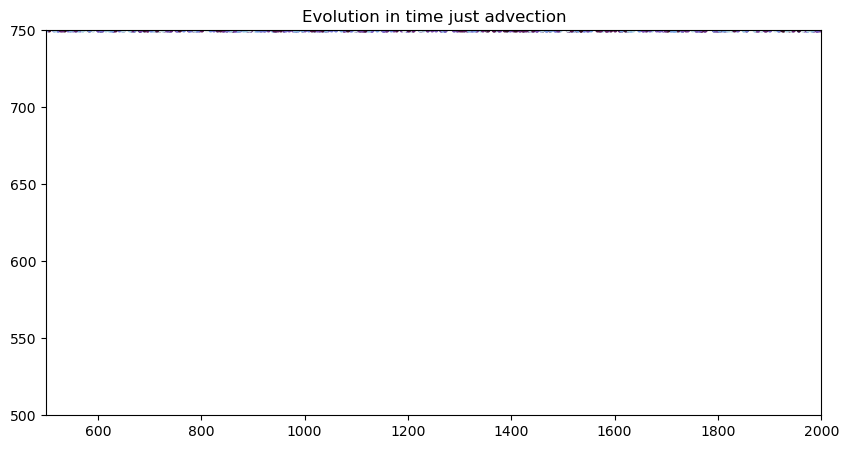

In [34]:
ss =[]
ani = anim2(dat,fps=1)
f = r"/home/jvalenti/MOAD/animations/box.gif" 
FFwriter = animation.FFMpegWriter()
ani.save(f, writer = FFwriter)

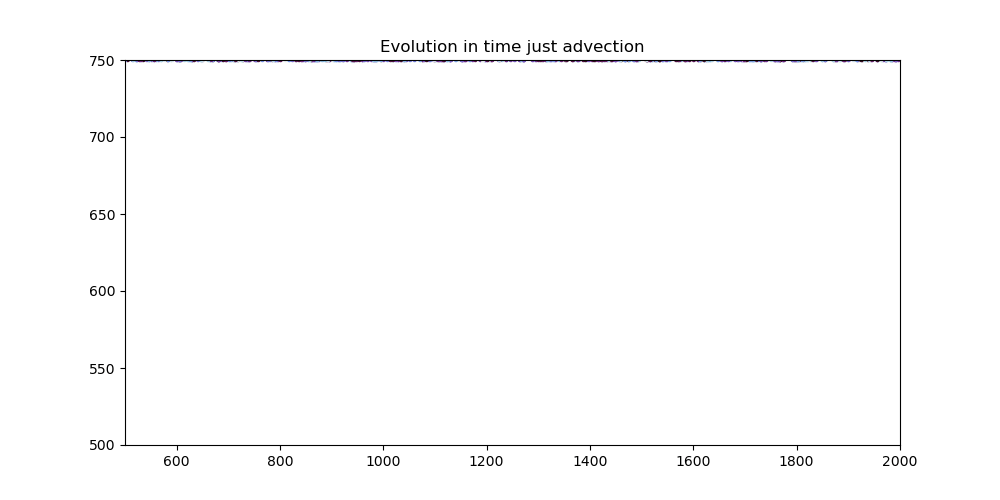

In [35]:
from IPython.display import Image
with open(f,'rb') as anim:
     display(Image(anim.read()))

In [14]:
# fig = plt.figure(figsize=(4,7))
# def update(frame):
#         fr = round(frame)
#         plt.clf()
#         ploting(fr)
# anim = animation.FuncAnimation(fig, update, frames=np.arange(0,23,1))
# f2 = r"/home/jvalenti/MOAD/animations/anim.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f2, writer = FFwriter)

In [15]:
# with open(f2,'rb') as anim:
#      display(Image(anim.read()))